# Analysis of King County bike infractions for Central Seattle Greenways

#### Ethan C. Campbell

For questions, contact me at ethanchenbell@gmail.com.

In [1]:
%matplotlib inline
from numpy import *
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
from datetime import datetime, timedelta
import glob
import platform

from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:100% !important; }</style>"))

# choose root directory for data files
if platform.system() == 'Darwin':
    data_dir = '/Users/Ethan/Documents/Finances and records/2020-06-30 - Central Seattle Greenways/'
elif platform.system() == 'Linux':
    data_dir = '/dat1/ethancc/CSG/'

In [2]:
# load annual bike infraction data transcribed from Seattle Municipal Court online table (some of this data since purged from online)
seattle_summaries = pd.read_excel(data_dir + '2020-07-18 - Seattle Municipal Court bike violations (transcribed from online table).xlsx',
                                 index_col=0)
display(seattle_summaries)

,"Bicycle Helmet Required (9.10.010, 9.15.010)",Rider Rights/Duties Violation (11.44.020),R/W in Crosswalk (11.44.100),Riding on Road Rules Violation (11.44.040),No/Improper Lamps/Reflectors (11.44.160),Yield R/W on Public Path (11.44.120),No/Improper Hand Signals (11.44.140),Unsafe Pass on Right (11.44.080),No/Improper Brakes (11.44.200),Ride More Than 2 Abreast Road/Sidewalk (11.44.060),Clinging/Attaching to Vehicle (11.44.240),Control (11.44.260)
Year,,,,,,,,,,,,
2011,607,140,11,4,13,6,1,4,0,0,1,2
2012,306,124,11,3,14,1,2,2,0,0,1,1
2013,341,197,7,2,10,1,2,4,0,0,0,0
2014,168,108,4,2,4,4,1,1,0,0,0,1
2015,76,81,6,3,6,3,0,5,0,0,1,0
2016,41,71,4,2,6,1,1,2,0,0,0,0
2017,33,34,9,3,6,2,3,3,1,0,0,0
2018,46,78,5,6,7,3,4,5,0,1,0,0
2019,29,65,7,6,4,2,2,1,1,0,0,1


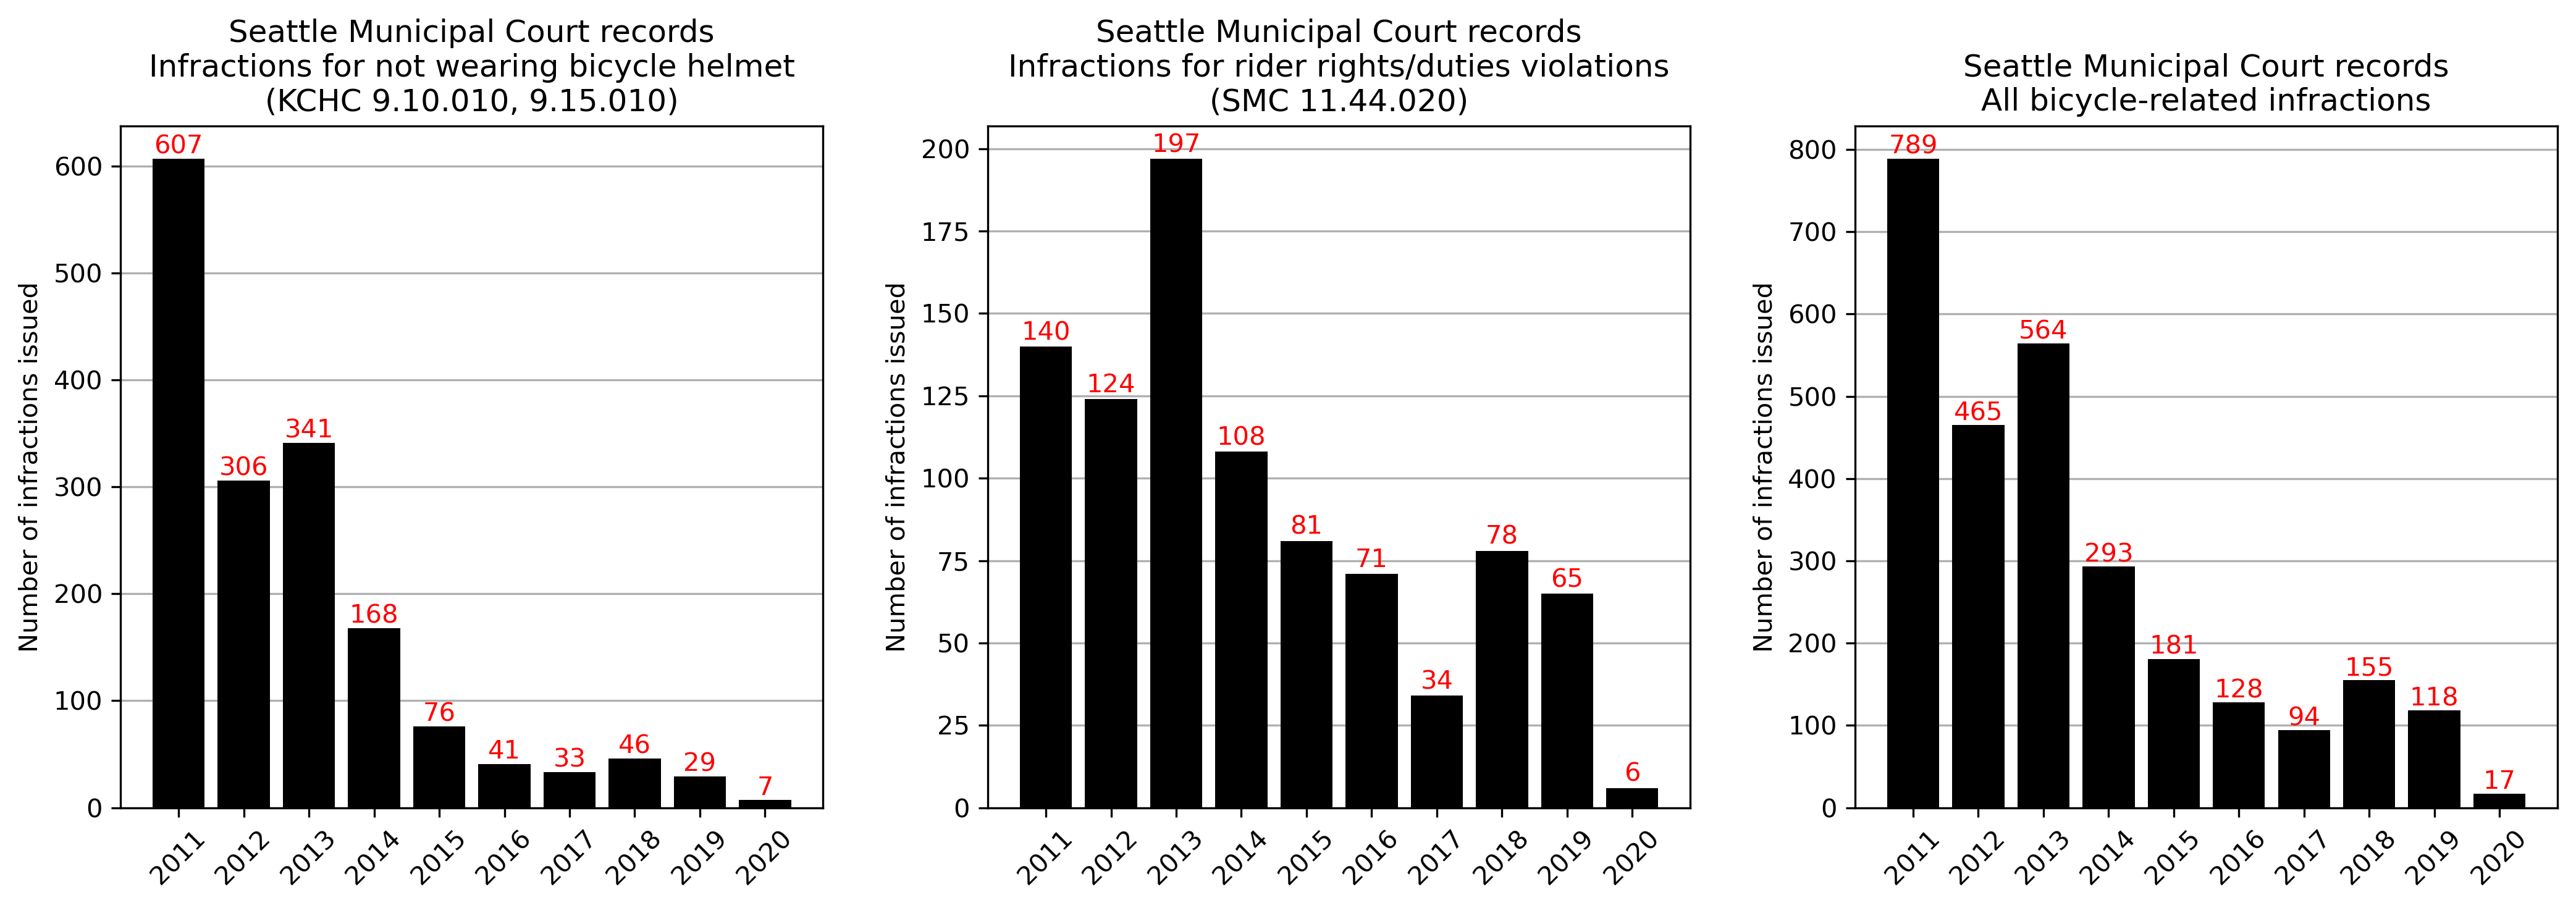

In [3]:
# plot annual data for selected Seattle bike infractions

x = seattle_summaries['Bicycle Helmet Required (9.10.010, 9.15.010)'].index
y = seattle_summaries['Bicycle Helmet Required (9.10.010, 9.15.010)'].values
plt.figure(figsize=(14,5),facecolor='w')
plt.subplot(1,3,1)
plt.grid(axis='y',zorder=1)
plt.bar(x,y,color='k',zorder=2)
plt.xticks(x,rotation=45)
plt.ylabel('Number of infractions issued')
plt.title('Seattle Municipal Court records\nInfractions for not wearing bicycle helmet\n(KCHC 9.10.010, 9.15.010)')
for i, y_val in enumerate(y):
    plt.text(x[i],y_val+5,str(y_val),c='r',fontweight='regular',horizontalalignment='center')

x = seattle_summaries['Rider Rights/Duties Violation (11.44.020)'].index
y = seattle_summaries['Rider Rights/Duties Violation (11.44.020)'].values
plt.subplot(1,3,2)
plt.grid(axis='y',zorder=1)
plt.bar(x,y,color='k',zorder=2)
plt.xticks(x,rotation=45)
plt.ylabel('Number of infractions issued')
plt.title('Seattle Municipal Court records\nInfractions for rider rights/duties violations\n(SMC 11.44.020)')
for i, y_val in enumerate(y):
    plt.text(x[i],y_val+2,str(y_val),c='r',fontweight='regular',horizontalalignment='center')
 
if 'Total' in seattle_summaries: del seattle_summaries['Total']
seattle_summaries['Total'] = seattle_summaries.sum(axis=1)
x = seattle_summaries['Total'].index
y = seattle_summaries['Total'].values
plt.subplot(1,3,3)
plt.grid(axis='y',zorder=1)
plt.bar(x,y,color='k',zorder=2)
plt.xticks(x,rotation=45)
plt.ylabel('Number of infractions issued')
plt.title('Seattle Municipal Court records\nAll bicycle-related infractions')
for i, y_val in enumerate(y):
    plt.text(x[i],y_val+6,str(y_val),c='r',fontweight='regular',horizontalalignment='center')
plt.tight_layout()

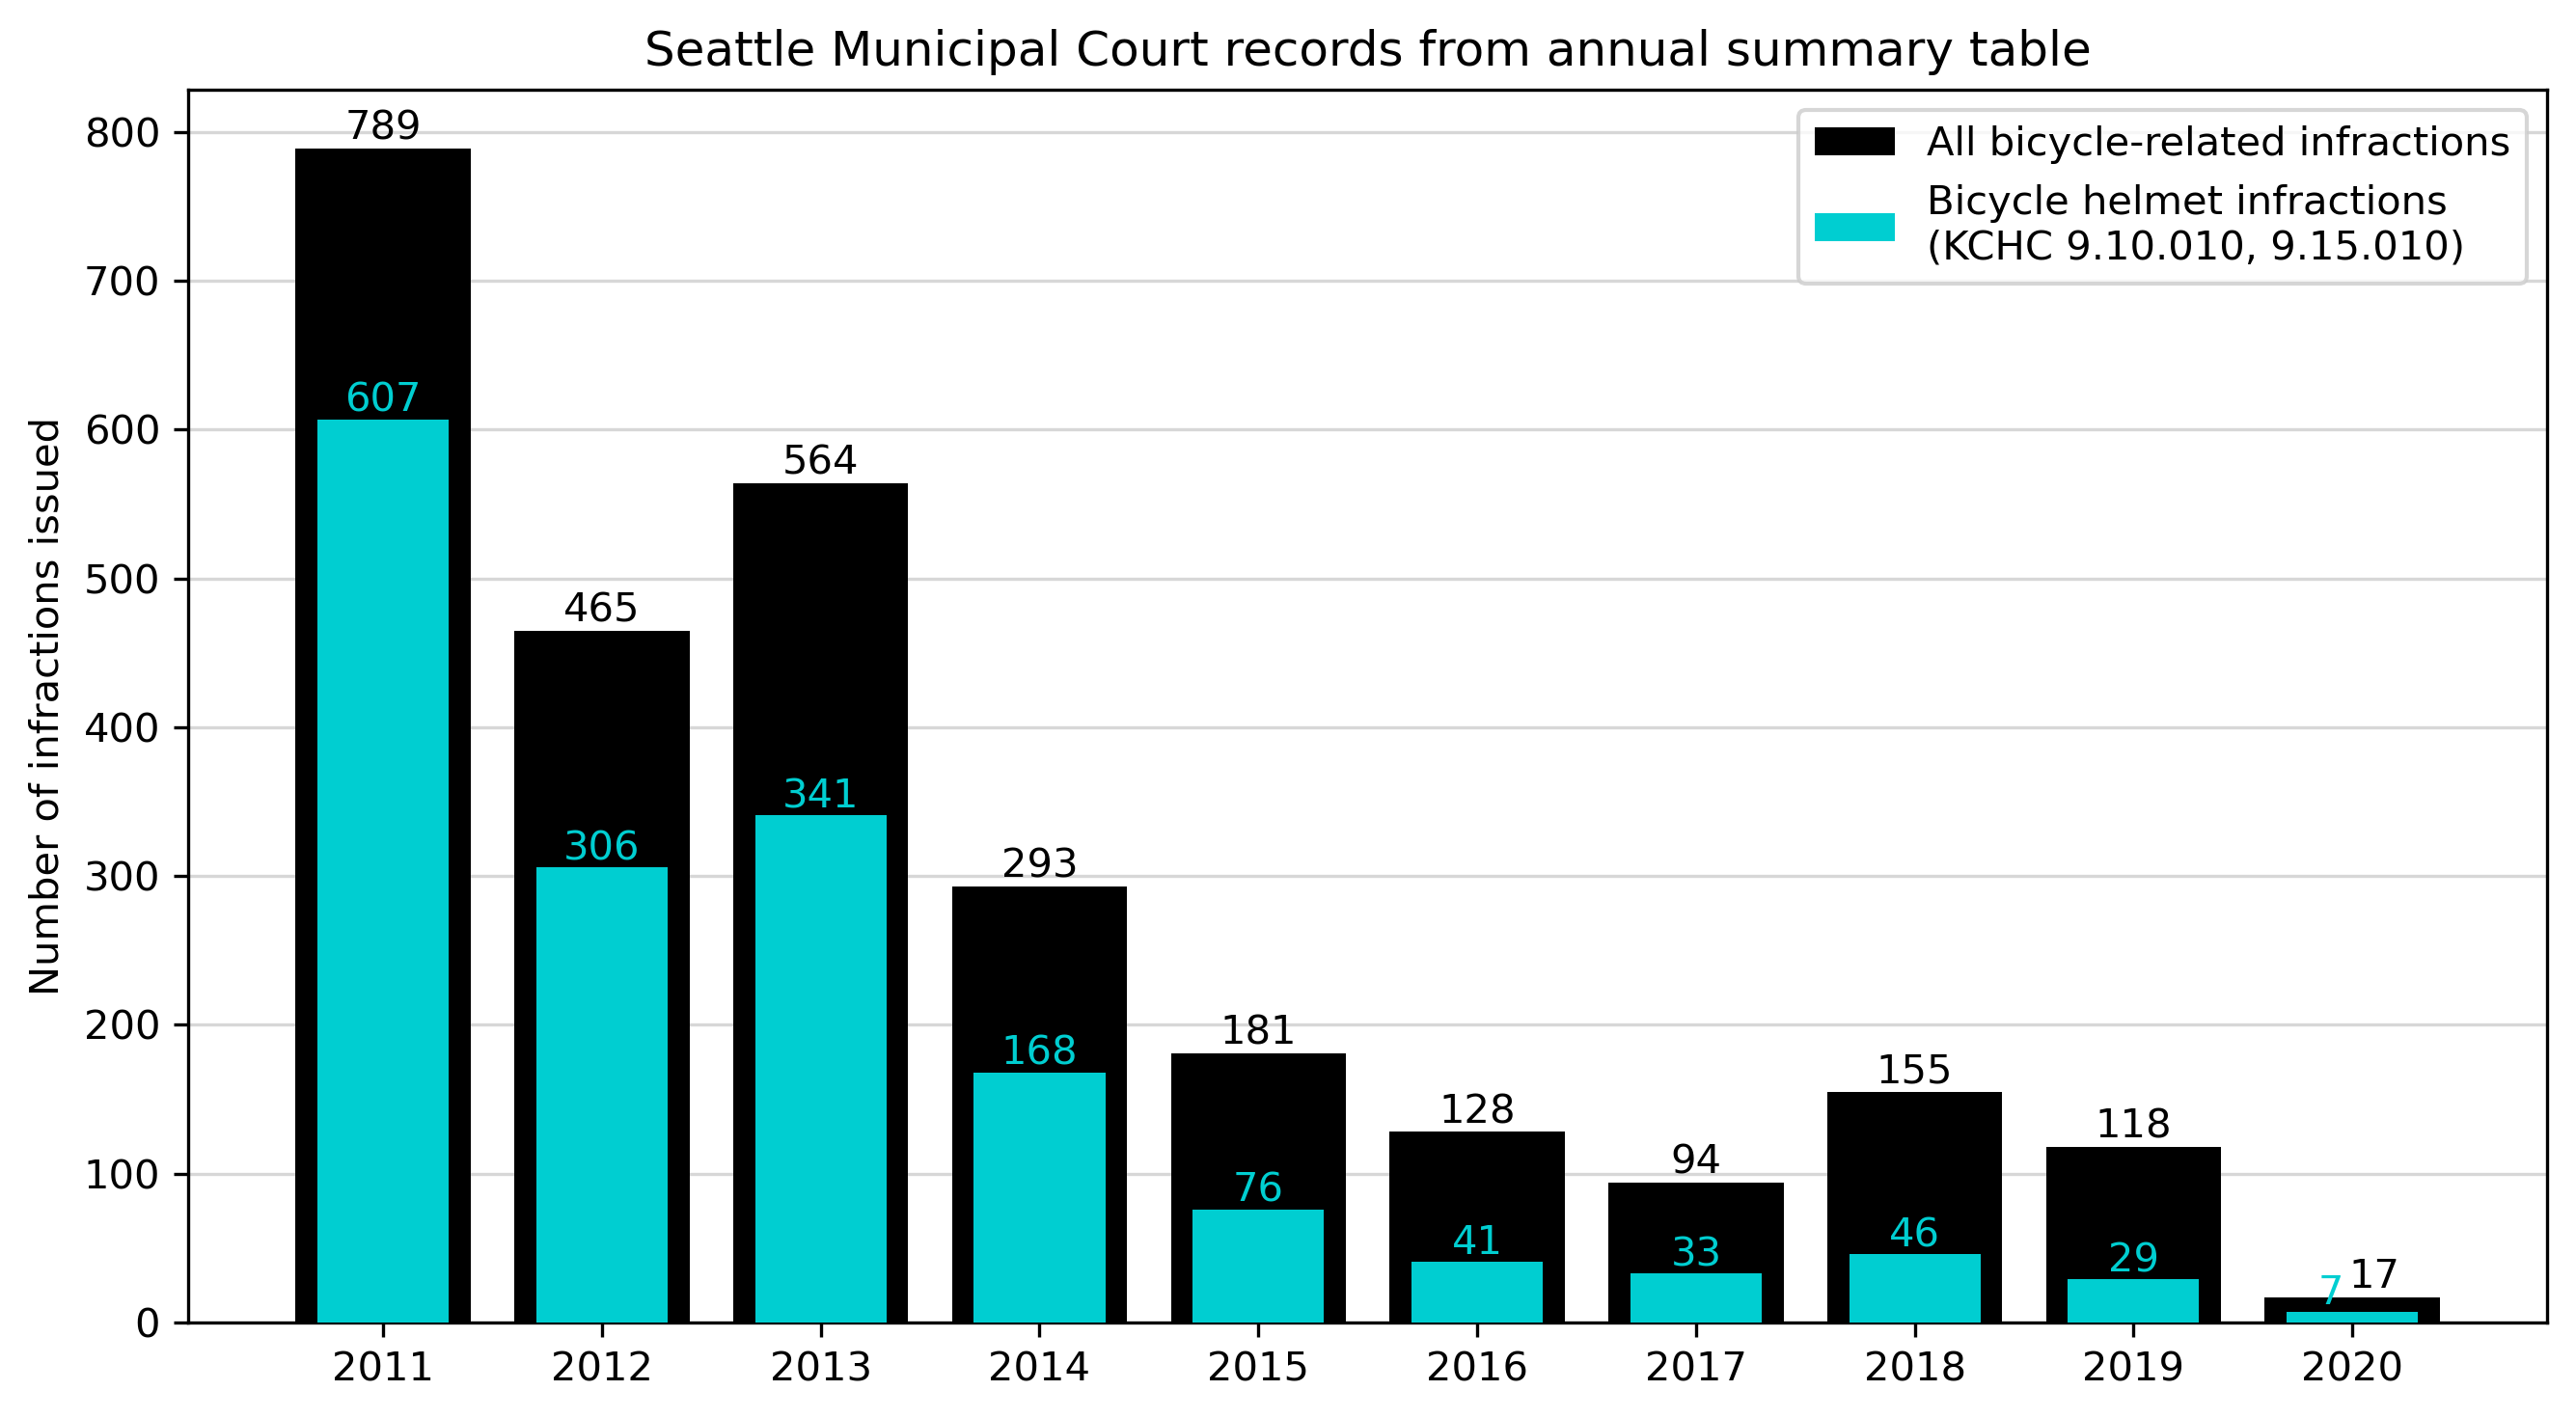

In [4]:
# plot annual data for selected Seattle bike infractions, shown differently

plt.figure(figsize=(9,5),facecolor='w')
if 'Total' in seattle_summaries: del seattle_summaries['Total']
seattle_summaries['Total'] = seattle_summaries.sum(axis=1)
x = seattle_summaries['Total'].index
y = seattle_summaries['Total'].values
plt.grid(axis='y',alpha=0.5,zorder=1)
plt.bar(x,y,color='k',zorder=2,label='All bicycle-related infractions')
for i, y_val in enumerate(y):
    if i == 9: label_offset = 0.1
    else:      label_offset = 0.0
    plt.text(x[i]+label_offset,y_val+6,str(y_val),c='k',fontweight='regular',horizontalalignment='center')

x = seattle_summaries['Bicycle Helmet Required (9.10.010, 9.15.010)'].index
y = seattle_summaries['Bicycle Helmet Required (9.10.010, 9.15.010)'].values
plt.bar(x,y,color='darkturquoise',width=0.6,zorder=3,
        label='Bicycle helmet infractions\n(KCHC 9.10.010, 9.15.010)')
for i, y_val in enumerate(y):
    if i == 9: label_offset = -0.1
    else:      label_offset = 0.0
    plt.text(x[i]+label_offset,y_val+5,str(y_val),c='darkturquoise',
             fontweight='regular',horizontalalignment='center')

plt.xticks(x)
plt.legend(frameon=True)
plt.ylabel('Number of infractions issued')
plt.title('Seattle Municipal Court records from annual summary table')
plt.tight_layout()

In [5]:
# load Seattle Municipal Court infraction records from 2017-2020
seattle_mc_new = pd.read_excel(data_dir + '2020-07-16 - Seattle Municipal Court bicycle violations (2017-01-01 to 2020-06-30).xlsx',
                               index_col=None,parse_dates=[0,1])
seattle_mc_new['Defendant Race'] = seattle_mc_new['Defendant Race'].fillna('U')   # handle entries missing Defendant Race information
display(seattle_mc_new)

# extract helmet violations into separate sheet
seattle_mc_new_helmet = seattle_mc_new[seattle_mc_new['Violation Description'] == 'BICYCLE HELMET REQUIRED'].copy()

#####

# load Seattle Municipal Court infraction records from 2003-2016 (incomplete due to purge schedule)
seattle_mc_old = pd.read_excel(data_dir + '2020-07-20 - Seattle Municipal Court bicycle violations (2003-01-01 to 2016-12-31).xlsx',
                               index_col=None,parse_dates=[0,1])
seattle_mc_old['Defendant Race'] = seattle_mc_old['Defendant Race'].fillna('U')   # handle entries missing Defendant Race information
display(seattle_mc_old)

# extract helmet violations into separate sheet
seattle_mc_old_helmet = seattle_mc_old[seattle_mc_old['Violation Description'] == 'BICYCLE HELMET REQUIRED'].copy()

#####

# merge old and new data
seattle_mc_combined = pd.concat([seattle_mc_old,seattle_mc_new])
seattle_mc_combined_helmet = pd.concat([seattle_mc_old_helmet,seattle_mc_new_helmet])

,Violation Date,Filing Date,Citation Number,Violation Code,Violation Description,Violation Time,Violation Location,Officer First Name,Officer Middle Initial,Officer Last Name,Officer Number,Defendant Race,Defendant Gender
0,2017-01-09,2017-01-10,12915476,KCHC9.10.010,BICYCLE HELMET REQUIRED,1330,NaN,JAMES,NaN,OLSON,7316,U,M
1,2017-01-09,2017-01-10,12915476,KCHC9.10.010,BICYCLE HELMET REQUIRED,1330,NaN,CHRISTOPHER,J,MYERS,7601,U,M
2,2017-01-16,2017-01-17,12922381,SMC11.44.160,BIKE NO/IMPROPER LAMPS/REFLECTORS,638,NaN,JOHN,D,RANDLE,8337,W,M
3,2017-01-15,2017-01-17,12922380,SMC11.44.020,BIKE RIDER RIGHTS/DUTIES VIOLATION,542,NaN,JOHN,D,RANDLE,8337,W,M
4,2017-01-29,2017-02-01,12921049,SMC11.44.160,BIKE NO/IMPROPER LAMPS/REFLECTORS,1835,NaN,FRANKLIN,D,POBLOCKI,6613,W,M
...,...,...,...,...,...,...,...,...,...,...,...,...,...
442,2020-05-19,2020-06-23,12948137,SMC11.44.020,BIKE RIDER RIGHTS/DUTIES VIOLATION,1732,NaN,PRESTON,J,TURK,8468,W,M
443,2020-04-27,2020-06-23,12982637,KCHC9.10.010,BICYCLE HELMET REQUIRED,1537,NaN,ALEX,J,PRATT,7643,W,M
444,2020-04-27,2020-06-23,12982637,KCHC9.10.010,BICYCLE HELMET REQUIRED,1537,NaN,DAVID,S,WARNOCK,8389,W,M
445,2020-05-01,2020-06-23,12947249,KCHC9.10.010,BICYCLE HELMET REQUIRED,1708,NaN,SEAN,D,CULBERTSON,7662,W,M


,Violation Date,Filing Date,Citation Number,Violation Code,Violation Description,Violation Time,Violation Location,Officer First Name,Officer Middle Initial,Officer Last Name,Officer Number,Defendant Race,Defendant Gender
0,2003-02-03,2003-02-05,10168275,11.44.020,RIGHTS AND DUTIES OF RIDERS,0,NaN,4438,DEBORAH,D,BROOKS,W,M
1,2003-02-04,2003-02-05,10415746,11.44.020,RIGHTS AND DUTIES OF RIDERS,1055,NaN,4253,ALAN,P,CARR,U,M
2,2003-03-02,2003-03-03,1065971,11.44.040,"BIKE, RIDE ON ROAD",225,NaN,6167,CHAD,D,ZENTNER,B,M
3,2003-03-02,2003-03-03,1065971,11.44.040,"BIKE, RIDE ON ROAD",225,NaN,6264,JON,A,ENGSTROM,B,M
4,2003-03-02,2003-03-03,1065971,11.44.160,"BIKE, LAMPS/REFLECTORS",225,NaN,6167,CHAD,D,ZENTNER,B,M
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2970,2016-11-08,2016-11-09,12923672,SMC11.44.160,BIKE NO/IMPROPER LAMPS/REFLECTORS,2035,NaN,7726,JARED,D,LEVITT,B,M
2971,2016-11-08,2016-11-14,12916028,SMC11.44.020,BIKE RIDER RIGHTS/DUTIES VIOLATION,1615,NaN,8354,JUSTIN,T,O'DELL,B,M
2972,2016-12-01,2016-12-06,12900828,SMC11.44.020,BIKE RIDER RIGHTS/DUTIES VIOLATION,1608,NaN,7775,CAROLINE,D,OSKAM,W,M
2973,2016-12-08,2016-12-08,6Z1182465,SMC11.44.020,BIKE RIDER RIGHTS/DUTIES VIOLATION,1311,900 BLOCK OF E PIKE ST,7723,DEVLIN,A,CAREY,U,M


In [6]:
# define function to load US Census Bureau American Community Survey (ACS) demographic data

# data obtained from, e.g. for Seattle: https://data.census.gov/cedsci/table?q=Seattle%20city,%20Washington&g=1600000US5363000&hidePreview=true&tid=ACSDP5Y2018.DP05&table=DP05
# note this grouping of racial categories is with probable phenotypical presentation in mind:
#    - 'Black' includes those listed in 'Two or more races' as 'Black and White' and 'Black and Native American'
#    - 'Asian_PacIs' includes those listed in 'Two or more races' as 'Asian and White'
#    - 'NativeAm_AlaskanNat' includes those listed in 'Two or more races' as 'Native American and White'

def load_census(city_abbrev,span,years=arange(2010,2018+1)):
    """
    Args:
        city_abbrev: e.g. 'Seattle', 'Federal_Way', etc.
        span: ACS span in years (1 or 5)
        years: ACS year or years to load (exact year for ACS 1-year or final year for ACS 5-year, e.g. 2010 for 2006-2010)
    """
    root_dir = data_dir + '2020-07-18 - US Census Bureau American Community Survey (ACS) data/'
    city_dir = '{0}_ACS_{1}_yr/'.format(city_abbrev,span)
    if type(years) == int: years = [years]
    census_data = pd.DataFrame(index=years,columns=['Total_population','Asian_PacIs','Black','NativeAm_AlaskanNat','White','Other'])
    for year in years:
        filename_wildcard = 'ACSDP{0}Y{1}.DP05_data*.csv'.format(span,year)
        filename = glob.glob(root_dir + city_dir + filename_wildcard)[0]
        raw_census_data = pd.read_csv(filename,header=1)
        if 'Percent!!RACE!!One race!!Asian' in raw_census_data.columns:
            header = 'Percent!!RACE!!'
        else:
            header = 'Percent Estimate!!RACE!!Total population!!'
        tot_pop = raw_census_data['Estimate!!RACE!!Total population'].values[0]
        api_percent = raw_census_data[header + 'One race!!Asian'].values[0] + \
                      raw_census_data[header + 'One race!!Native Hawaiian and Other Pacific Islander'].values[0] + \
                      raw_census_data[header + 'Two or more races!!White and Asian'].values[0]
        black_percent = raw_census_data[header + 'One race!!Black or African American'].values[0] + \
                        raw_census_data[header + 'Two or more races!!White and Black or African American'].values[0] + \
                        raw_census_data[header + 'Two or more races!!Black or African American and American Indian and Alaska Native'].values[0]
        natam_percent = raw_census_data[header + 'One race!!American Indian and Alaska Native'].values[0] + \
                        raw_census_data[header + 'Two or more races!!White and American Indian and Alaska Native'].values[0]
        white_percent = raw_census_data[header + 'One race!!White'].values[0]
        other_percent = 100.0 - api_percent - black_percent - natam_percent - white_percent
        if other_percent < 0.0: print('Uh oh... summed total of racial percentages is greater than 100%')
        census_data.loc[year] = {'Total_population':tot_pop,'Asian_PacIs':api_percent,'Black':black_percent,
                                 'NativeAm_AlaskanNat':natam_percent,'White':white_percent,'Other':other_percent}
    if span == 5: census_data['5_yr_period'] = ['{0}-{1}'.format(yr-4,yr) for yr in census_data.index]
    return census_data

In [7]:
# load racial statistics from SDOT 2013 Bicycle Participation Phone Survey
# data information and access:
#     - https://www.seattle.gov/transportation/projects-and-programs/programs/bike-program/bike-data
#     - https://www.seattle.gov/Documents/Departments/SDOT/BikeProgram/13-5004bikesdotcrosstab.pdf

sdot_survey = pd.read_excel(data_dir + '2020-07-18 - SDOT 2013 Bicycle Participation Phone Survey - racial statistics.xlsx',
                            index_col=0)
sdot_survey

,Percent riding a few times per year,Number riding a few times per year,Percent riding a few times per month or more,Number riding a few times per month or more,Average percent
Race/ethnicity,,,,,
All,100,69.00,100,110.0,100.0
Black,5,3.45,4,4.4,4.5
White,72,49.68,80,88.0,76.0
Hispanic,2,1.38,2,2.2,2.0
Asian,18,12.42,11,12.1,14.5
Other,2,1.38,4,4.4,3.0
Refuse,1,0.69,0,0.0,0.5
White_Hispanic,74,51.06,82,90.2,78.0
Residual,3,2.07,3,3.3,3.0


### Historical record of bike infractions by year

**Source: Seattle Times, "The cop and the courier: Seattle’s top-ticketing officer, and its most-ticketed cyclist" by Gene Balk (July 15, 2015)**

In [8]:
from IPython.display import Image
display(Image(url='https://static.seattletimes.com/wp-content/uploads/2015/07/aed058d2-2b4d-11e5-bef9-f00a1a6eacb9-1560x1133.jpg',
              width=500,height=300))

seattle_hist_all = pd.Series(index=arange(1990,2015),
                             data=[143,149,172,125,161,157,142,179,101,141,150,152,159,
                                   197,195,215,478,289,577,525,656,733,405,501,270])

# add more recent infraction totals from Seattle Municipal Court summary table online (since deleted, but transcribed above)
for year in seattle_summaries.index:
    seattle_hist_all[int(year)] = seattle_summaries['Total'][year]

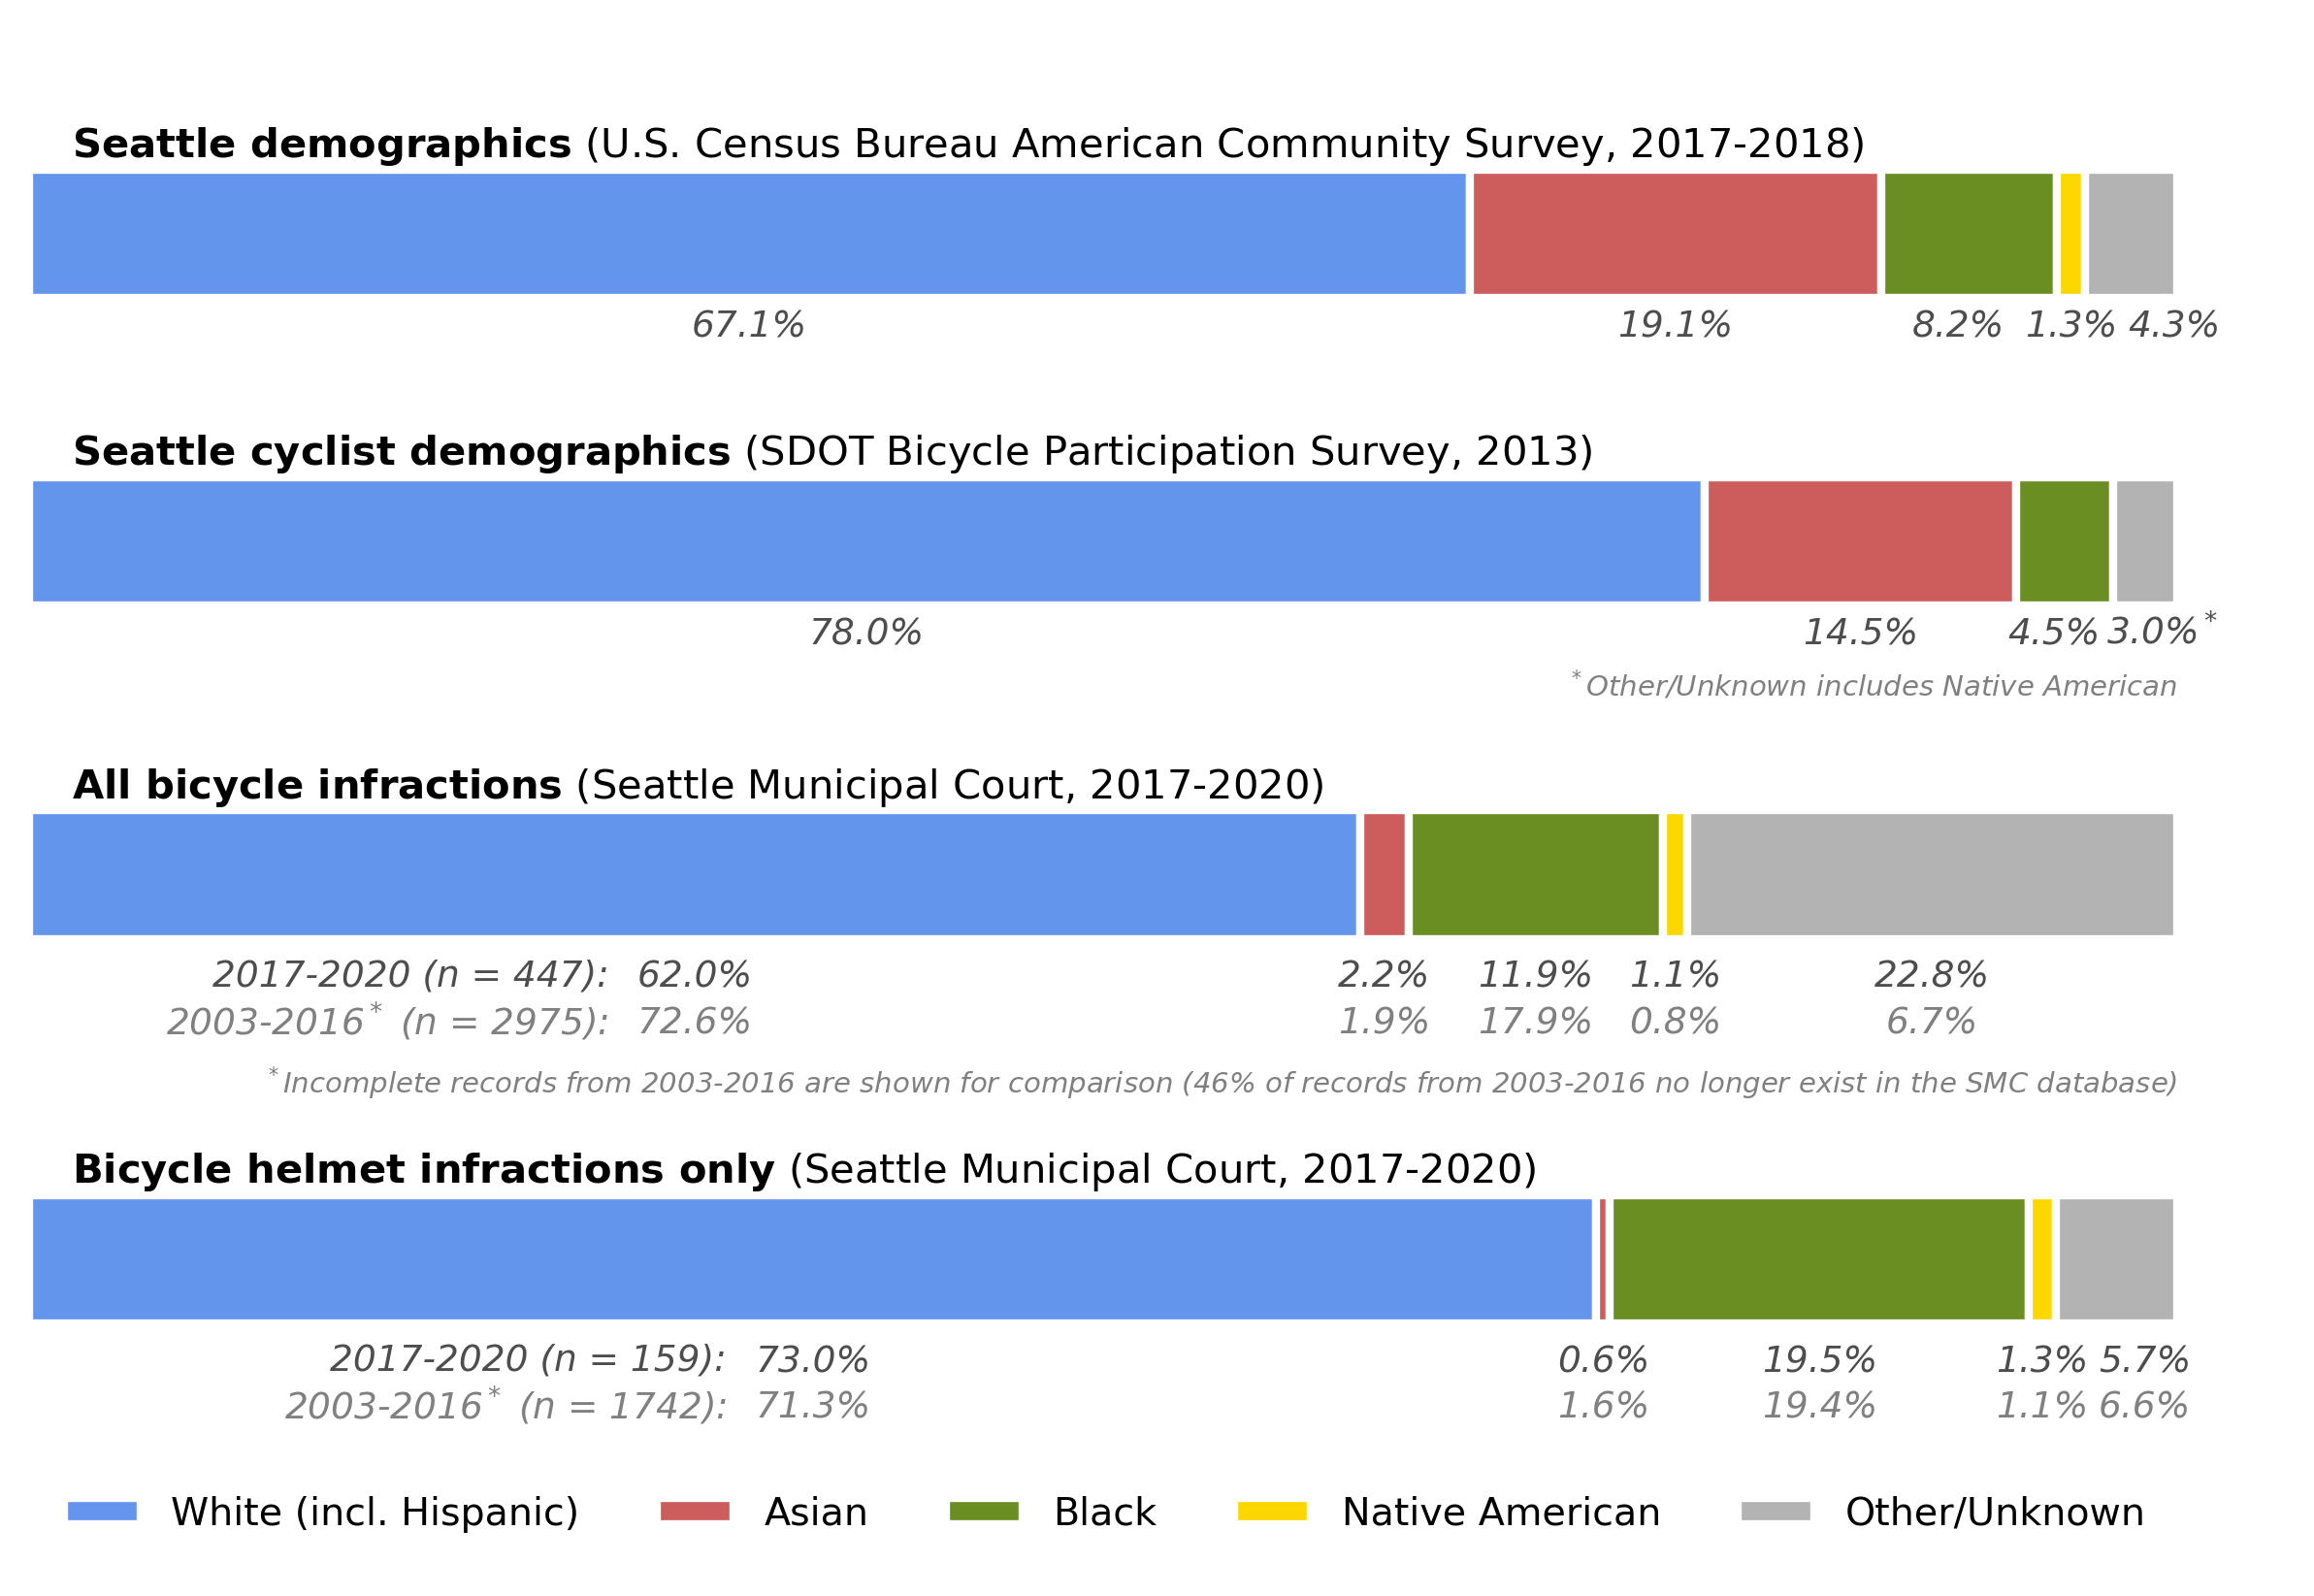

In [9]:
# plot comparison of Seattle bike infraction data, Seattle demographics, and Seattle cyclist demographics

plt.figure(figsize=(10,7),facecolor='w')

seattle_census = load_census('Seattle',1).loc[2017:2018].mean()
labels = ['White (incl. Hispanic)','Asian','Black','Native American','Other/Unknown']
colors = ['cornflowerblue','indianred','olivedrab','gold','0.7']
bump_label = [0,0,-0.5,0,2.0]
label_star = [0,0,0,0,0]
y_baseline = 5.2
widths = array([seattle_census['White'],
                seattle_census['Asian_PacIs'],
                seattle_census['Black'],
                seattle_census['NativeAm_AlaskanNat'],
                seattle_census['Other']])
h2 = plt.barh(y_baseline,widths,height=0.5,left=array([0,*cumsum(widths)[:-1]]),color=colors,edgecolor='w',linewidth=2.0)
for w_idx, w in enumerate(widths):
    plt.text(array([0,*cumsum(widths)[:-1]])[w_idx] + w/2 + bump_label[w_idx], y_baseline-0.4,'{0:.1f}%{1}'.format(w,'*'*label_star[w_idx]),
             horizontalalignment='center',fontstyle='italic',color='0.3',fontsize=9)
plt.text(2,y_baseline+0.3,r'$\bf{Seattle~demographics}$ (U.S. Census Bureau American Community Survey, 2017-2018)')

labels = ['White (incl. Hispanic)','Asian','Black','Other/Unknown']  # Other includes Native American here
colors = ['cornflowerblue','indianred','olivedrab','0.7']
bump_label = [0,0,-.5,.8]
label_star = [0,0,0,1]
y_baseline = 4.0
widths = array([sdot_survey['Average percent'].loc['White_Hispanic'],
                sdot_survey['Average percent'].loc['Asian'],
                sdot_survey['Average percent'].loc['Black'],
                sdot_survey['Average percent'].loc['Residual']])
h1 = plt.barh(y_baseline,widths,height=0.5,left=array([0,*cumsum(widths)[:-1]]),color=colors,edgecolor='w',linewidth=2.0)
for w_idx, w in enumerate(widths):
    plt.text(array([0,*cumsum(widths)[:-1]])[w_idx] + w/2 + bump_label[w_idx], y_baseline-0.4,'{0:.1f}%{1}'.format(w,'$^*$'*label_star[w_idx]),
             horizontalalignment='center',fontstyle='italic',color='0.3',fontsize=9)
plt.text(2,y_baseline+0.3,r'$\bf{Seattle~cyclist~demographics}$ (SDOT Bicycle Participation Survey, 2013)')
plt.text(100,y_baseline-0.6,'$^*$Other/Unknown includes Native American',
         fontstyle='italic',horizontalalignment='right',color='0.5',fontsize=7)

labels = ['White (incl. Hispanic)','Asian','Black','Native American','Other/Unknown']
colors = ['cornflowerblue','indianred','olivedrab','gold','0.7']
bump_label = [0,0,0,0,0]
label_star = [0,0,0,0,0]
y_baseline = 2.7
widths = array([100 * sum(seattle_mc_new['Defendant Race'] == 'W') / len(seattle_mc_new),
                100 * sum(seattle_mc_new['Defendant Race'] == 'A') / len(seattle_mc_new),
                100 * sum(seattle_mc_new['Defendant Race'] == 'B') / len(seattle_mc_new),
                100 * sum(seattle_mc_new['Defendant Race'] == 'I') / len(seattle_mc_new),
                100 * sum(seattle_mc_new['Defendant Race'] == 'U') / len(seattle_mc_new)])
widths_old = array([100 * sum(seattle_mc_old['Defendant Race'] == 'W') / len(seattle_mc_old),
                    100 * sum(seattle_mc_old['Defendant Race'] == 'A') / len(seattle_mc_old),
                    100 * sum(seattle_mc_old['Defendant Race'] == 'B') / len(seattle_mc_old),
                    100 * sum(seattle_mc_old['Defendant Race'] == 'I') / len(seattle_mc_old),
                    100 * sum(seattle_mc_old['Defendant Race'] == 'U') / len(seattle_mc_old)])
h3 = plt.barh(y_baseline,widths,height=0.5,left=array([0,*cumsum(widths)[:-1]]),color=colors,edgecolor='w',linewidth=2.0)
for w_idx, w in enumerate(widths):
    plt.text(array([0,*cumsum(widths)[:-1]])[w_idx] + widths[w_idx]/2 + bump_label[w_idx], y_baseline-0.4,'{0:.1f}%{1}'.format(w,'*'*label_star[w_idx]),
             horizontalalignment='center',verticalalignment='center',fontstyle='italic',color='0.3',fontsize=9)
for w_idx, w in enumerate(widths_old):
    plt.text(array([0,*cumsum(widths)[:-1]])[w_idx] + widths[w_idx]/2 + bump_label[w_idx], y_baseline-0.58,'{0:.1f}%{1}'.format(w,'*'*label_star[w_idx]),
             horizontalalignment='center',verticalalignment='center',fontstyle='italic',color='0.5',fontsize=9)
plt.text(2,y_baseline+0.3,r'$\bf{All~bicycle~infractions}$ (Seattle Municipal Court, 2017-2020)')
plt.text(widths[0]/2 - 4,y_baseline-0.395,'2017-2020 (n = {0}):'.format(len(seattle_mc_new)),
         style='italic',horizontalalignment='right',verticalalignment='center',color='0.3',fontsize=9)
plt.text(widths[0]/2 - 4,y_baseline-0.57,'2003-2016$^*$ (n = {0}):'.format(len(seattle_mc_old)),
         style='italic',horizontalalignment='right',verticalalignment='center',color='0.5',fontsize=9)
percent_missing = 100 * (1 - len(seattle_mc_old)/(sum(seattle_hist_all.loc[2003:2016])))
plt.text(100,y_baseline-0.85,'$^*$Incomplete records from 2003-2016 are shown for comparison ({0:.0f}% of records from 2003-2016 no longer exist in the SMC database)'.format(percent_missing),
         fontstyle='italic',horizontalalignment='right',color='0.5',fontsize=7)

bump_label = [0,0,0,0,1.3]
label_star = [0,0,0,0,0]
y_baseline = 1.2
widths = array([100 * sum(seattle_mc_new_helmet['Defendant Race'] == 'W') / len(seattle_mc_new_helmet),
                100 * sum(seattle_mc_new_helmet['Defendant Race'] == 'A') / len(seattle_mc_new_helmet),
                100 * sum(seattle_mc_new_helmet['Defendant Race'] == 'B') / len(seattle_mc_new_helmet),
                100 * sum(seattle_mc_new_helmet['Defendant Race'] == 'I') / len(seattle_mc_new_helmet),
                100 * sum(seattle_mc_new_helmet['Defendant Race'] == 'U') / len(seattle_mc_new_helmet)])
widths_old = array([100 * sum(seattle_mc_old_helmet['Defendant Race'] == 'W') / len(seattle_mc_old_helmet),
                    100 * sum(seattle_mc_old_helmet['Defendant Race'] == 'A') / len(seattle_mc_old_helmet),
                    100 * sum(seattle_mc_old_helmet['Defendant Race'] == 'B') / len(seattle_mc_old_helmet),
                    100 * sum(seattle_mc_old_helmet['Defendant Race'] == 'I') / len(seattle_mc_old_helmet),
                    100 * sum(seattle_mc_old_helmet['Defendant Race'] == 'U') / len(seattle_mc_old_helmet)])
h3 = plt.barh(y_baseline,widths,height=0.5,left=array([0,*cumsum(widths)[:-1]]),color=colors,edgecolor='w',linewidth=2.0)
for w_idx, w in enumerate(widths):
    plt.text(array([0,*cumsum(widths)[:-1]])[w_idx] + widths[w_idx]/2 + bump_label[w_idx], y_baseline-0.4,'{0:.1f}%{1}'.format(w,'*'*label_star[w_idx]),
             horizontalalignment='center',verticalalignment='center',fontstyle='italic',color='0.3',fontsize=9)
for w_idx, w in enumerate(widths_old):
    plt.text(array([0,*cumsum(widths)[:-1]])[w_idx] + widths[w_idx]/2 + bump_label[w_idx], y_baseline-0.58,'{0:.1f}%{1}'.format(w,'*'*label_star[w_idx]),
             horizontalalignment='center',verticalalignment='center',fontstyle='italic',color='0.5',fontsize=9)
plt.text(2,y_baseline+0.3,r'$\bf{Bicycle~helmet~infractions~only}$ (Seattle Municipal Court, 2017-2020)')
plt.text(widths[0]/2 - 4,y_baseline-0.395,'2017-2020 (n = {0}):'.format(len(seattle_mc_new_helmet)),
         style='italic',horizontalalignment='right',verticalalignment='center',color='0.3',fontsize=9)
plt.text(widths[0]/2 - 4,y_baseline-0.57,'2003-2016$^*$ (n = {0}):'.format(len(seattle_mc_old_helmet)),
         style='italic',horizontalalignment='right',verticalalignment='center',color='0.5',fontsize=9)
plt.ylim([0,6.0])

plt.legend(h2,labels,ncol=5,frameon=False,loc='lower left',prop={'size':9.5});
plt.xticks([]); plt.yticks([])
plt.gca().spines['top'].set_visible(False); plt.gca().spines['bottom'].set_visible(False); plt.gca().spines['left'].set_visible(False); plt.gca().spines['right'].set_visible(False)

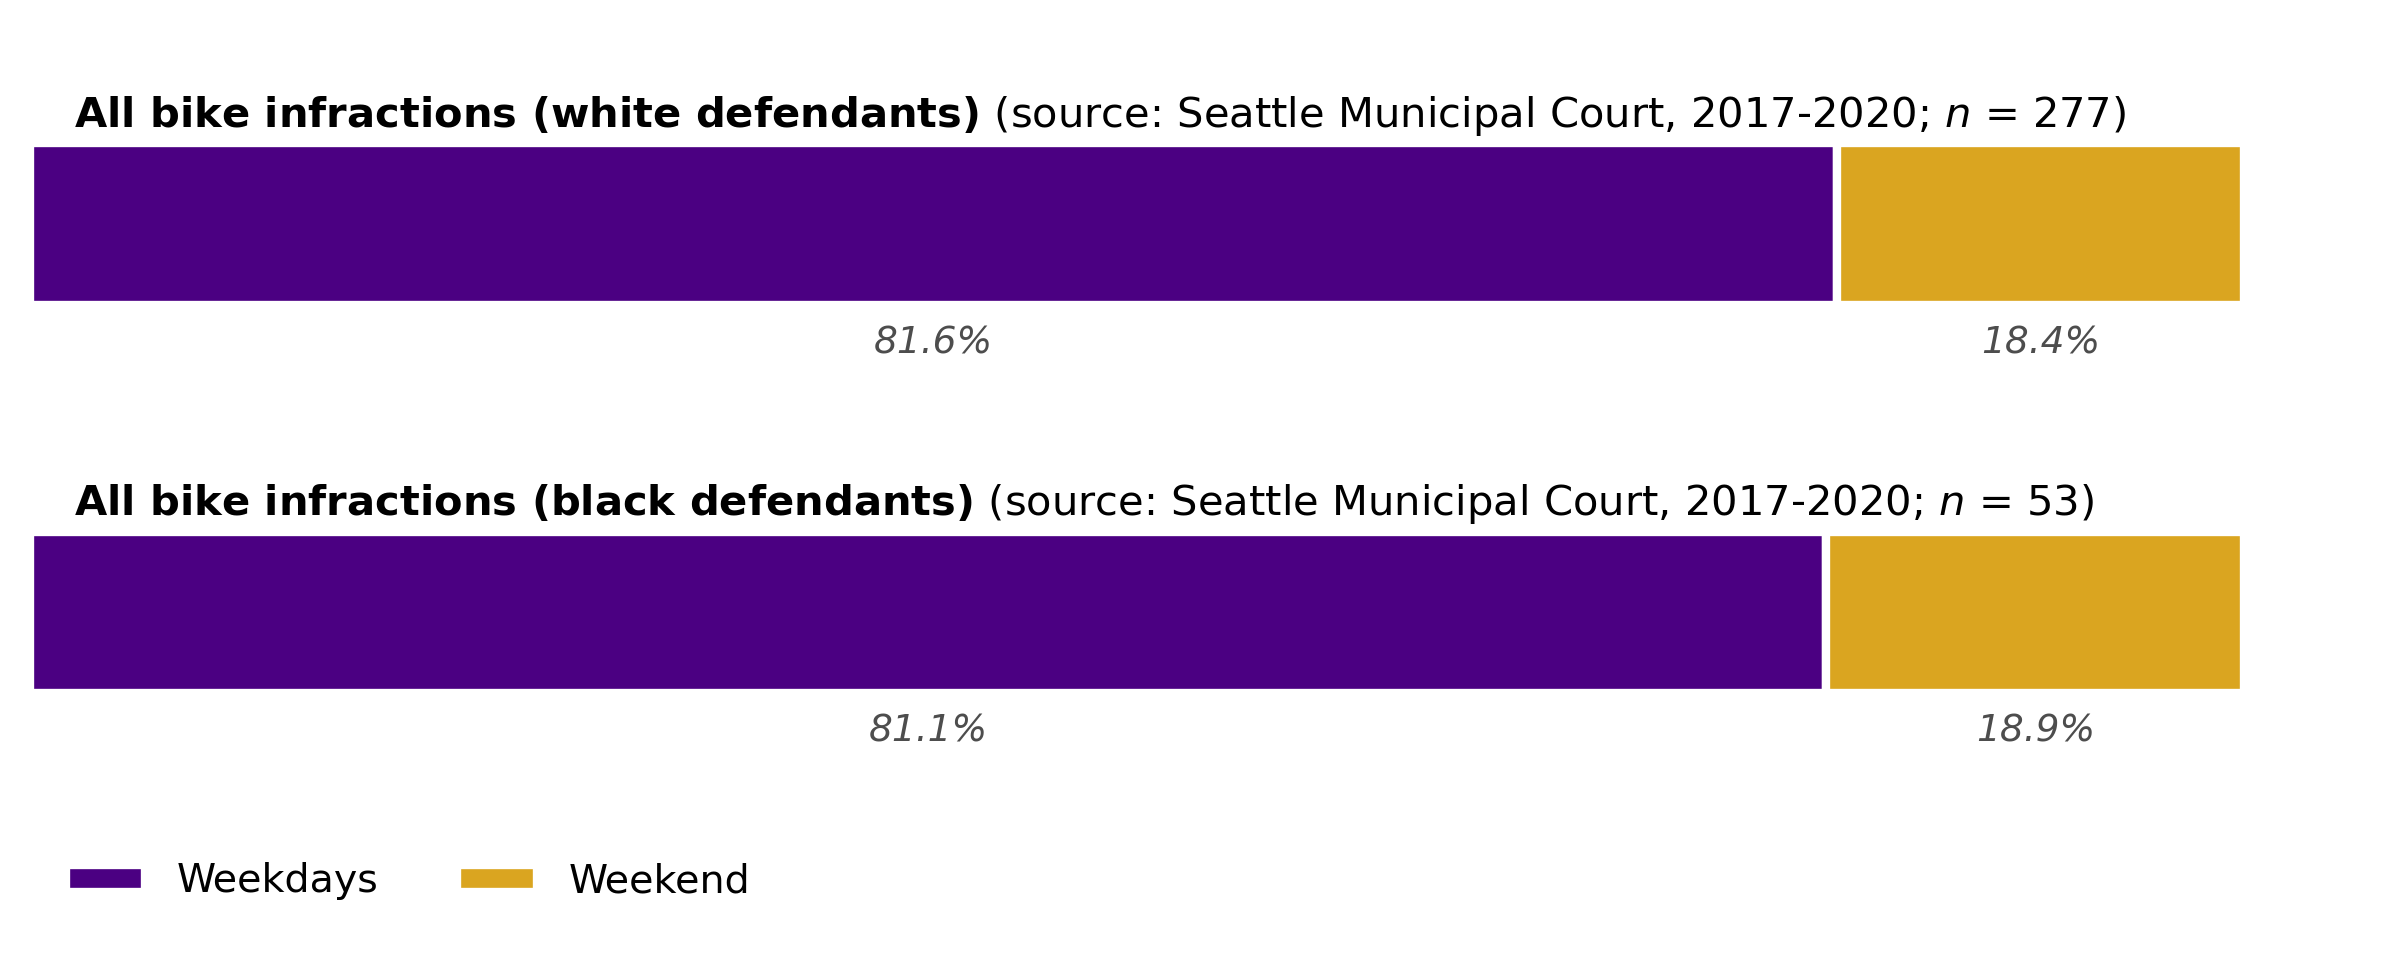

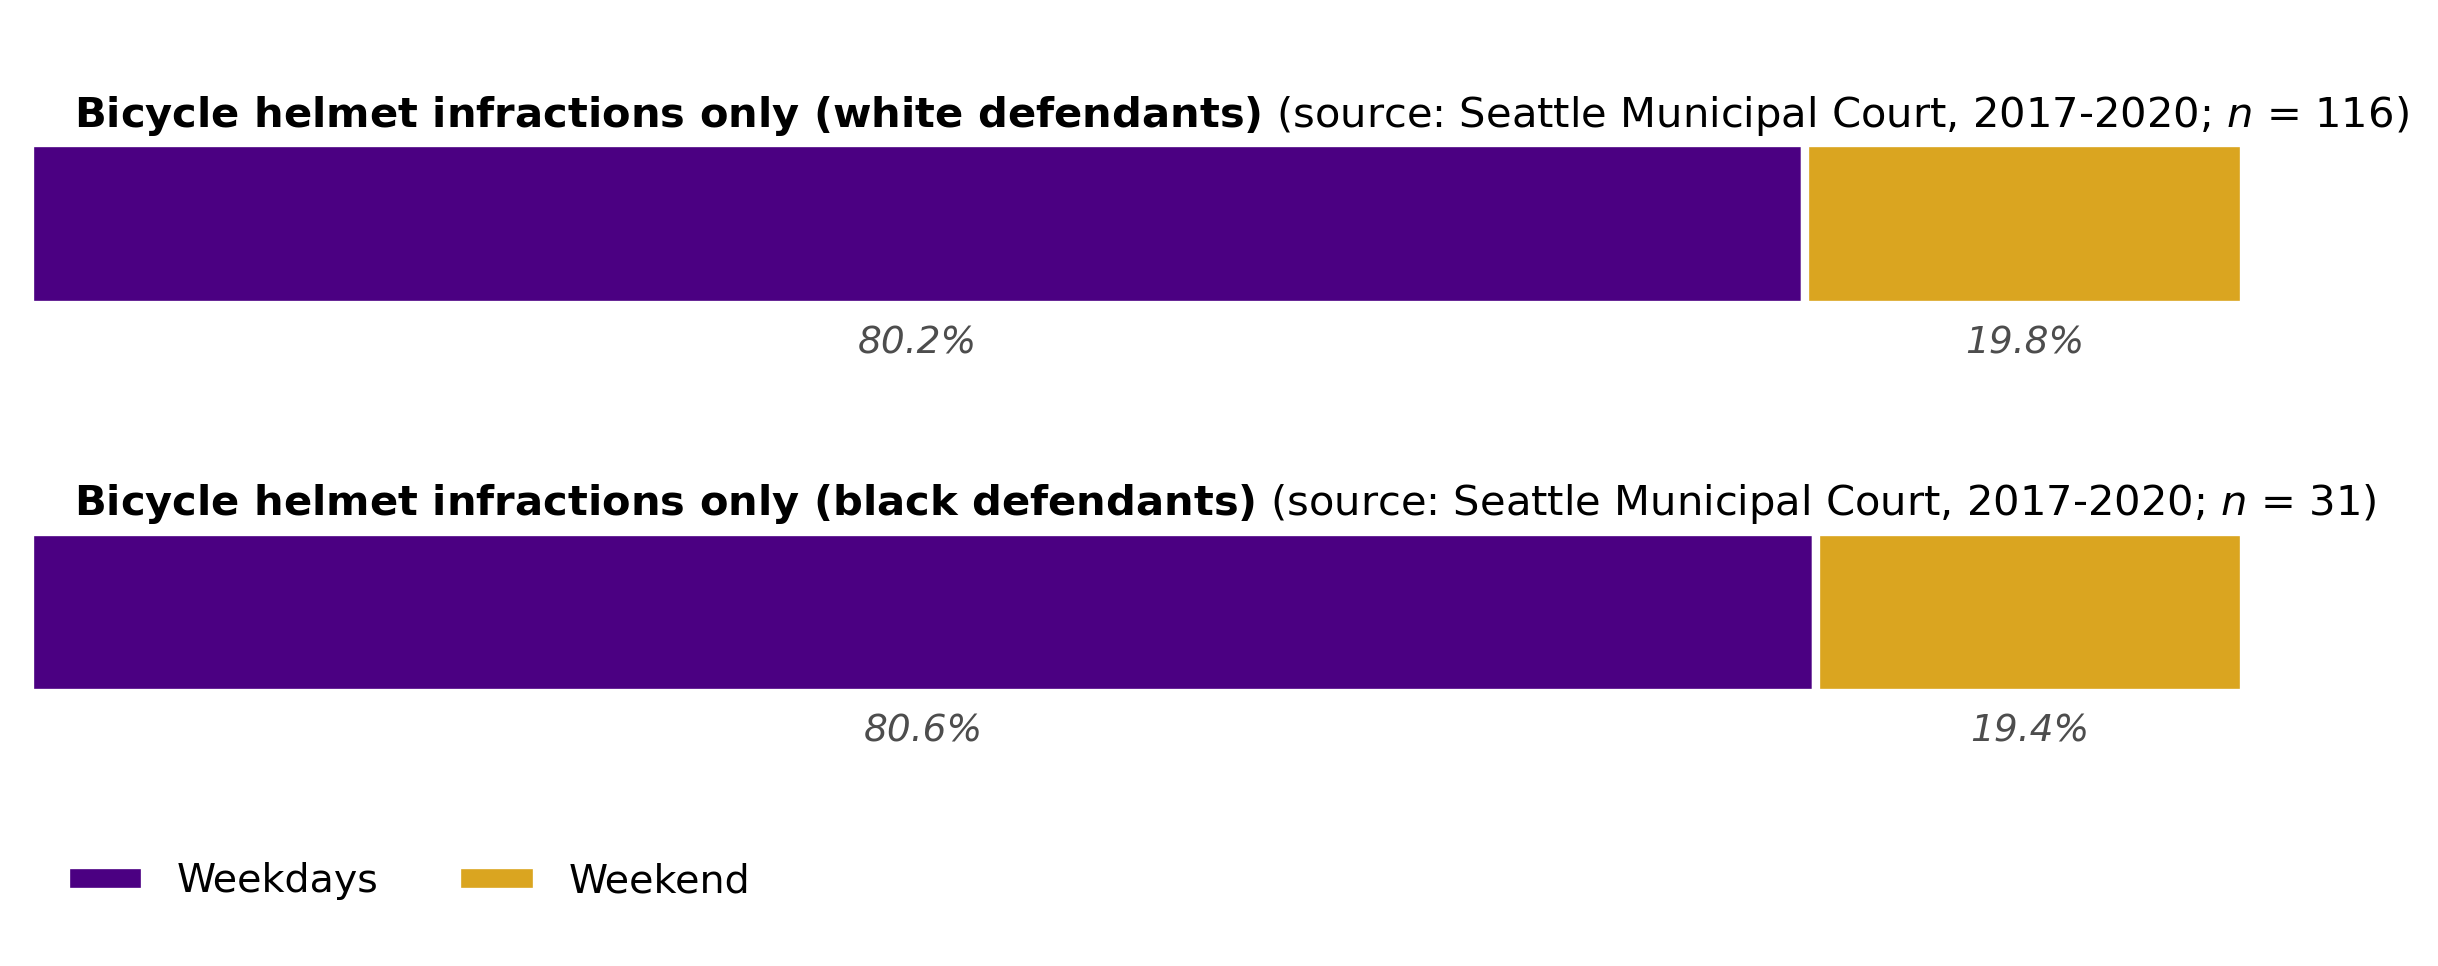

In [10]:
# analysis of weekdays in which infractions were written

dows_all_white = histogram([dt.dayofweek for dt in seattle_mc_new['Violation Date'][seattle_mc_new['Defendant Race'] == 'W']],
                           bins=arange(0,8))
dows_all_black = histogram([dt.dayofweek for dt in seattle_mc_new['Violation Date'][seattle_mc_new['Defendant Race'] == 'B']],
                           bins=arange(0,8))
dows_helmet_white = histogram([dt.dayofweek for dt in seattle_mc_new_helmet['Violation Date'][seattle_mc_new_helmet['Defendant Race'] == 'W']],
                           bins=arange(0,8))
dows_helmet_black = histogram([dt.dayofweek for dt in seattle_mc_new_helmet['Violation Date'][seattle_mc_new_helmet['Defendant Race'] == 'B']],
                           bins=arange(0,8))

which_infractions = [r'$\bf{All~bike~infractions~',r'$\bf{Bicycle~helmet~infractions~only~']
for r_idx, dows in enumerate([[dows_all_white,dows_all_black],[dows_helmet_white,dows_helmet_black]]):
    plt.figure(figsize=(10,4),facecolor='w')

    labels = ['Weekdays','Weekend']
    colors = ['indigo','goldenrod']
    bump_label = [0,0]
    label_star = [0,0]
    y_baseline = 2.2
    widths = array([100*sum(dows[0][0][0:5])/sum(dows[0][0]),100*sum(dows[0][0][5:7])/sum(dows[0][0])])
    h1 = plt.barh(y_baseline,widths,height=0.5,left=array([0,*cumsum(widths)[:-1]]),color=colors,edgecolor='w',linewidth=2.0)
    for w_idx, w in enumerate(widths):
        plt.text(array([0,*cumsum(widths)[:-1]])[w_idx] + w/2 + bump_label[w_idx], y_baseline-0.4,'{0:.1f}%{1}'.format(w,'*'*label_star[w_idx]),
                 horizontalalignment='center',fontstyle='italic',color='0.3',fontsize=9)
    plt.text(2,y_baseline+0.3,which_infractions[r_idx] + r'(white~defendants)}$ (source: Seattle Municipal Court, 2017-2020; ' \
                              + '$n$ = {0})'.format(sum(dows[0][0])))

    bump_label = [0,0]
    label_star = [0,0]
    y_baseline = 1.0
    widths = array([100*sum(dows[1][0][0:5])/sum(dows[1][0]),100*sum(dows[1][0][5:7])/sum(dows[1][0])])
    h2 = plt.barh(y_baseline,widths,height=0.5,left=array([0,*cumsum(widths)[:-1]]),color=colors,edgecolor='w',linewidth=2.0)
    for w_idx, w in enumerate(widths):
        plt.text(array([0,*cumsum(widths)[:-1]])[w_idx] + w/2 + bump_label[w_idx], y_baseline-0.4,'{0:.1f}%{1}'.format(w,'*'*label_star[w_idx]),
                 horizontalalignment='center',fontstyle='italic',color='0.3',fontsize=9)
    plt.text(2,y_baseline+0.3,which_infractions[r_idx] + r'(black~defendants)}$ (source: Seattle Municipal Court, 2017-2020; ' \
                              + '$n$ = {0})'.format(sum(dows[1][0])))

    plt.ylim([0,2.8])

    plt.legend(h2,labels,ncol=5,frameon=False,loc='lower left',prop={'size':9.5});
    plt.xticks([]); plt.yticks([])
    plt.gca().spines['top'].set_visible(False); plt.gca().spines['bottom'].set_visible(False); plt.gca().spines['left'].set_visible(False); plt.gca().spines['right'].set_visible(False)


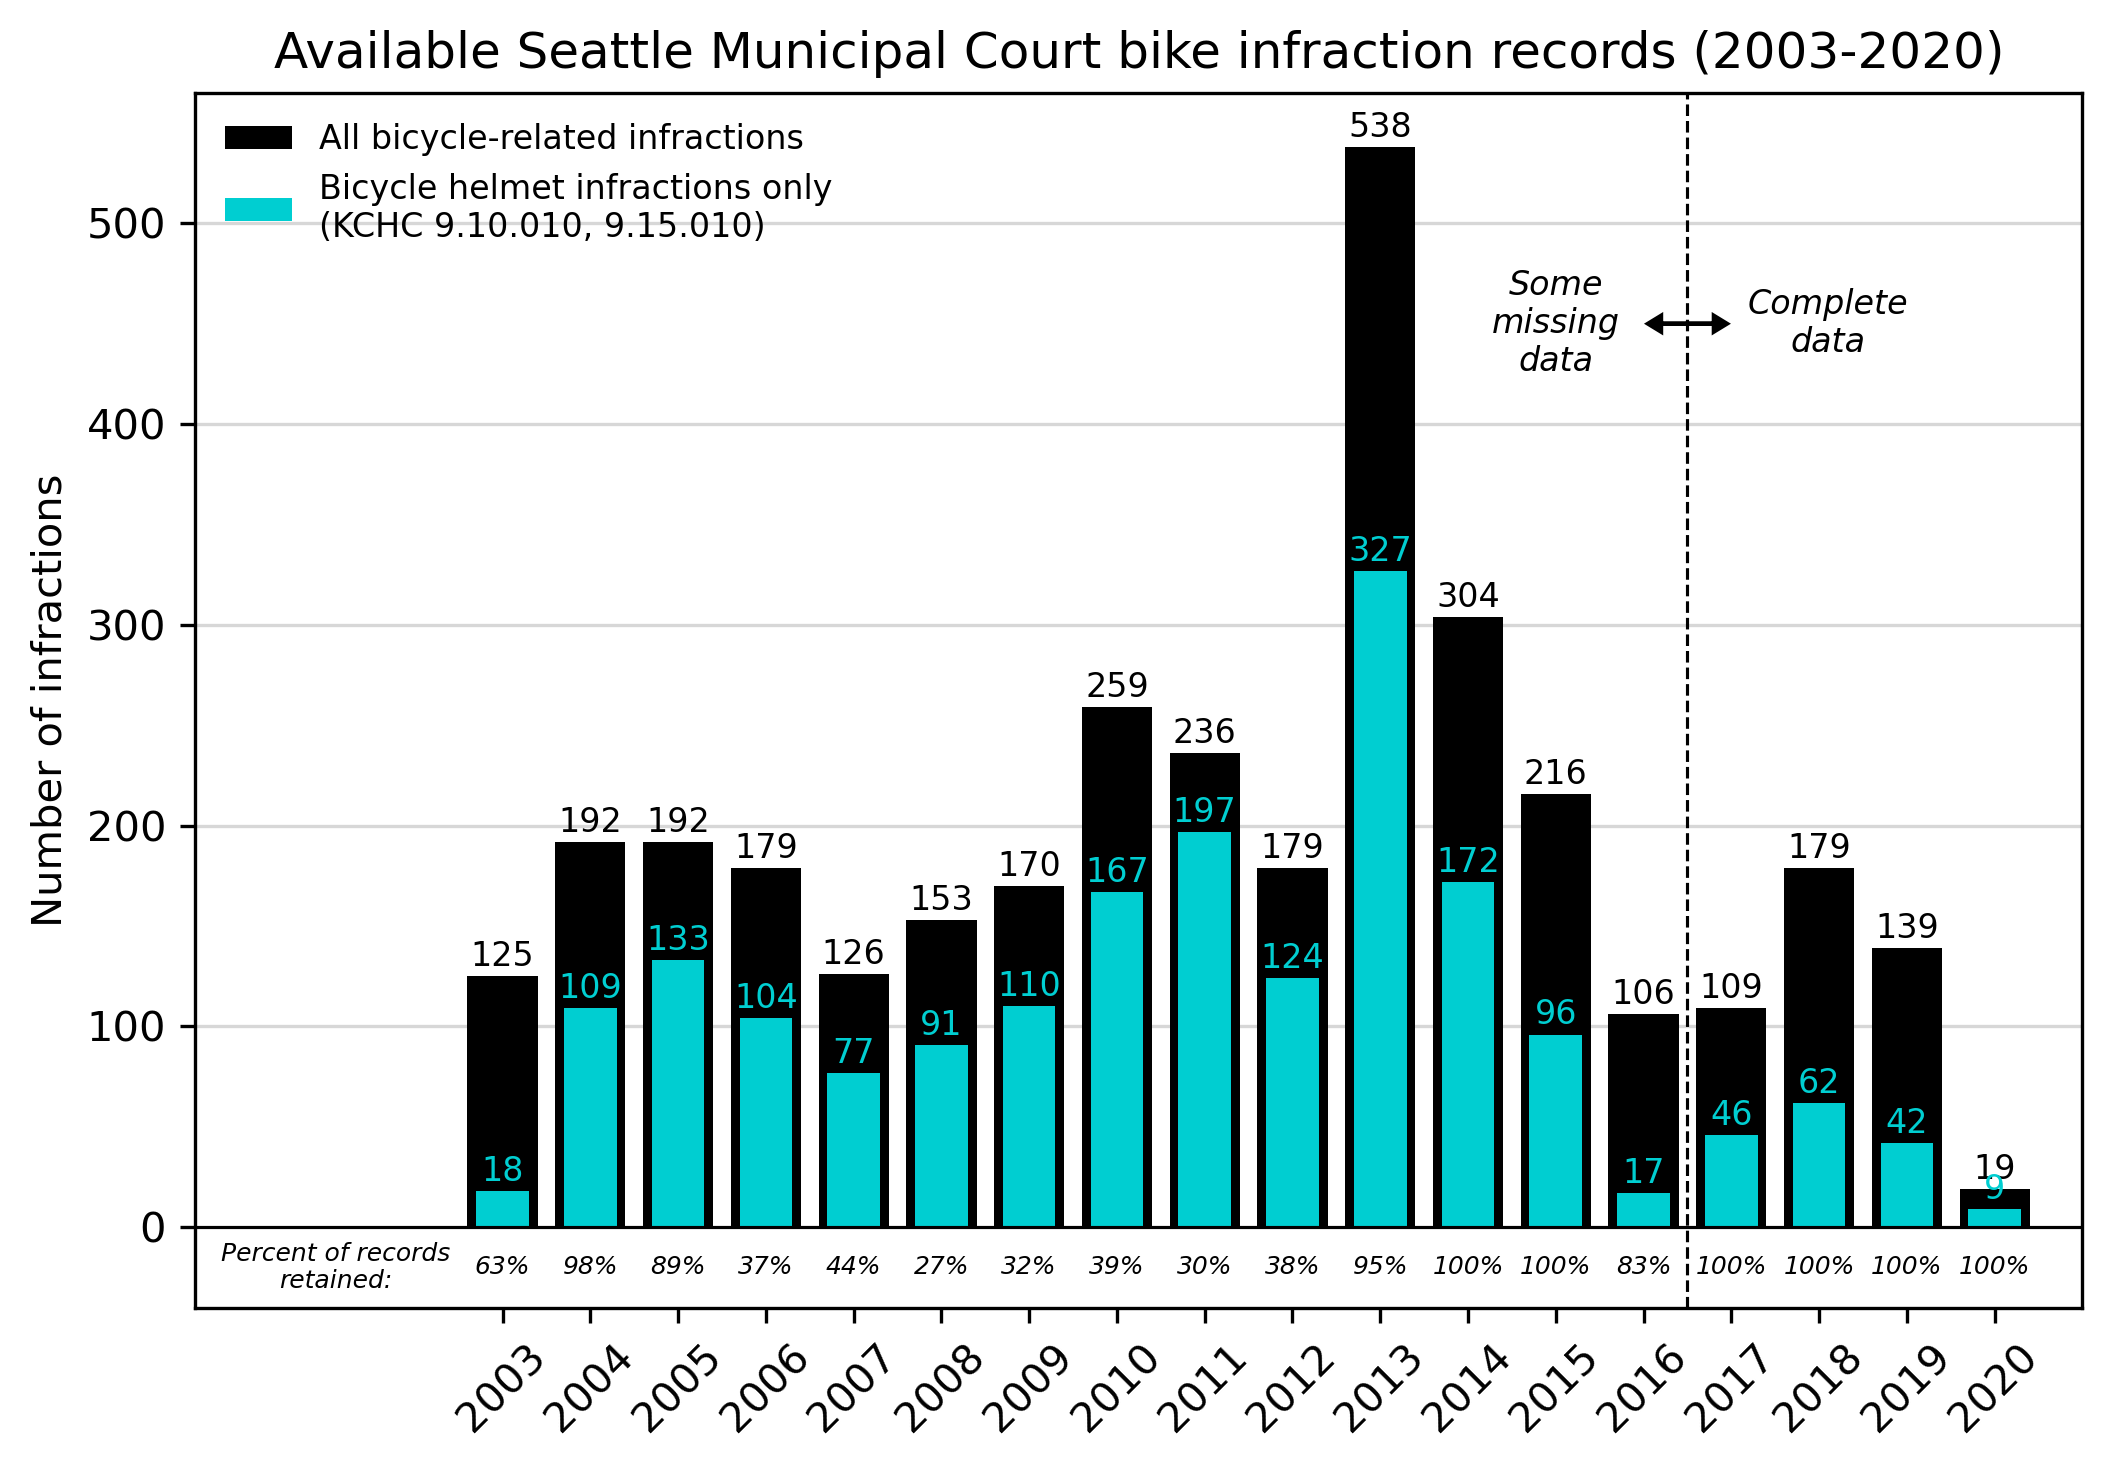

In [11]:
# plot time distribution of older (2003-2016), incomplete Seattle bike infraction records

plt.figure(figsize=(14,5),facecolor='w')
plt.subplot(1,2,1)

old_years_hist = histogram(seattle_mc_old['Violation Date'].dt.year,bins=arange(2003,2018))
x = old_years_hist[1][:-1]
y = old_years_hist[0]
plt.grid(axis='y',alpha=0.5,zorder=1)
plt.bar(x,y,color='k',zorder=2,label='All bicycle-related infractions')
for i, y_val in enumerate(y): plt.text(x[i],y_val+5,str(y_val),c='k',
                                       fontweight='regular',fontsize=8,horizontalalignment='center')
    
new_years_hist = histogram(seattle_mc_new['Violation Date'].dt.year,bins=arange(2017,2022))
x = new_years_hist[1][:-1]
y = new_years_hist[0]
plt.grid(axis='y',zorder=1)
plt.bar(x,y,color='k',zorder=2)
for i, y_val in enumerate(y): plt.text(x[i],y_val+5,str(y_val),c='k',
                                       fontweight='regular',fontsize=8,horizontalalignment='center')

old_years_helmet_hist = histogram(seattle_mc_old_helmet['Violation Date'].dt.year,bins=arange(2003,2018))
x = old_years_helmet_hist[1][:-1]
y = old_years_helmet_hist[0]
plt.bar(x,y,color='darkturquoise',zorder=3,width=0.6,label='Bicycle helmet infractions only\n(KCHC 9.10.010, 9.15.010)')
for i, y_val in enumerate(y): plt.text(x[i],y_val+5,str(y_val),c='darkturquoise',
                                       fontweight='regular',fontsize=8,horizontalalignment='center')
    
new_years_helmet_hist = histogram(seattle_mc_new_helmet['Violation Date'].dt.year,bins=arange(2017,2022))
x = new_years_helmet_hist[1][:-1]
y = new_years_helmet_hist[0]
plt.bar(x,y,color='darkturquoise',zorder=3,width=0.6)
for i, y_val in enumerate(y): plt.text(x[i],y_val+5,str(y_val),c='darkturquoise',
                                       fontweight='regular',fontsize=8,horizontalalignment='center')  
    
old_ylims = plt.ylim()
plt.plot([2016.5,2016.5],[-40,old_ylims[1]],c='k',ls='--',lw=0.75)
plt.arrow(2016.5,450,0.3,0,shape='full',head_length=0.15,head_width=8,color='k')
plt.arrow(2016.5,450,-0.3,0,shape='full',head_length=0.15,head_width=8,color='k')
plt.text(2018.1,450,'Complete\ndata',horizontalalignment='center',verticalalignment='center',style='italic',size=8)
plt.text(2015.0,450,'Some\nmissing\ndata',horizontalalignment='center',verticalalignment='center',style='italic',size=8)

plt.plot([1999.5,2021],[0,0],c='k',lw=0.75,zorder=4)
plt.ylim([-40,old_ylims[1]])
plt.xlim([1999.5,2021])

for year in arange(2003,2021):
    if year <= 2016:
        avail = old_years_hist[0][where(old_years_hist[1] == year)][0]
    elif year >= 2017:
        avail = new_years_hist[0][where(new_years_hist[1] == year)][0]
    frac_avail = min(100,100*avail/seattle_hist_all.loc[year])
    plt.text(year,-20,'{0:.0f}%'.format(frac_avail),horizontalalignment='center',verticalalignment='center',
             style='italic',size=6,color='k')
plt.text(2001.1,-20,'Percent of records\nretained:',horizontalalignment='center',verticalalignment='center',
         style='italic',color='k',size=6)

plt.legend(frameon=False,fontsize=8)
plt.xticks(arange(2003,2021),rotation=45)
plt.ylabel('Number of infractions')
plt.title('Available Seattle Municipal Court bike infraction records (2003-2020)')
plt.tight_layout()



# Preliminary analysis of other King County municipalities

In [67]:
# load data from Renton
renton_mc = pd.read_excel(data_dir + '2020-07-22 - Renton Municipal Court helmet infraction data (2007-08-20 to 2020-06-30).xlsx',
                          header=4,index_col=None,parse_dates=[0,5,10])
renton_census = load_census('Renton',1).loc[2010:2018].mean()
print('Renton MC white',100 * sum(renton_mc['Person Race Code'] == 'W') / len(renton_mc))
print('Renton MC Black',100 * sum(renton_mc['Person Race Code'] == 'B') / len(renton_mc))
print('Renton ACS white',renton_census['White'])
print('Renton ACS Black',renton_census['Black'])
# display(renton_mc)

# load data from Kent
kent_mc = pd.read_excel(data_dir + '2020-07-28 - Kent Municipal Court helmet infraction data (2007-10-30 to 2020-06-15).xlsx',
                        header=4,index_col=None,parse_dates=[0,6,12])
kent_mc = kent_mc.iloc[arange(1,len(kent_mc),2)]
kent_census = load_census('Kent',1).loc[2010:2018].mean()
print('Kent MC white',100 * sum(kent_mc['Person Race'] == 'White') / len(kent_mc))
print('Kent MC Black',100 * sum(kent_mc['Person Race'] == 'Black') / len(kent_mc))
print('Kent ACS white',kent_census['White'])
print('Kent ACS Black',kent_census['Black'])
# display(kent_mc)

# load data from Federal Way
fedway_mc = pd.read_excel(data_dir + '2020-08-05 - Federal Way Municipal Court helmet infraction data (2010-06-14 to 2014-06-08).xlsx',
                          header=0,index_col=None,parse_dates=[0])
fedway_race_only = array([str(entry)[0] for entry in fedway_mc['Race/Gender']])
fedway_race_only[fedway_race_only == 'n'] = 'U'
fedway_mc['Race'] = fedway_race_only
fedway_census = load_census('Federal_Way',1).loc[2010:2014].mean()
print('Federal Way MC white',100 * sum(fedway_mc['Race'] == 'W') / len(fedway_mc))
print('Federal Way MC Black',100 * sum(fedway_mc['Race'] == 'B') / len(fedway_mc))
print('Federal Way ACS white',fedway_census['White'])
print('Federal Way ACS Black',fedway_census['Black'])
# display(fedway_mc)

# load data from King County Sheriff's Office
kcso_mc = pd.read_excel(data_dir + '2020-07-27 - King County Sheriff\'s Office helmet infraction data (2010-03-16 to 2019-08-22).xlsx',
                        header=0,index_col=None,parse_dates=[0])
print('KCSO white',100 * sum(kcso_mc['Race'] == 'White') / len(kcso_mc))
print('KCSO Black',100 * sum(kcso_mc['Race'] == 'Black') / len(kcso_mc))
# display(kcso_mc)

Renton MC white 83.56164383561644
Renton MC Black 6.8493150684931505
Renton ACS white 51.45555555555555
Renton ACS Black 11.58888888888889
Kent MC white 54.60526315789474
Kent MC Black 9.868421052631579
Kent ACS white 53.97777777777778
Kent ACS Black 12.777777777777777
Federal Way MC white 36.36363636363637
Federal Way MC Black 18.181818181818183
Federal Way ACS white 62.14
Federal Way ACS Black 11.459999999999999
KCSO white 79.2
KCSO Black 8.0
